In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import StringIO
from scipy.fftpack import fft
from scipy.signal import firwin, remez, kaiser_atten, kaiser_beta
from scipy.signal import butter, filtfilt, buttord
from scipy.signal import butter, lfilter
from scipy.stats import entropy
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

In [2]:
signals_beth = pd.read_csv('data/datafinal/bethoven.dat', delimiter=' ', names = ['timestamp','counter','eeg','attention','meditation','blinking'])

#print('Estructura de la informacion:')
#print(signals_beth.head())

data_beth = signals_beth.values
eeg_beth = data_beth[:,2]

#print(len(eeg_beth))

signals_death = pd.read_csv('data/datafinal/deathmetal.dat', delimiter=' ', names = ['timestamp','counter','eeg','attention','meditation','blinking'])

#print('Estructura de la informacion:')
#print(signals_death.head())

data_death = signals_death.values
eeg_death = data_death[:,2]

#print(eeg_death)

signals_baseline = pd.read_csv('data/datafinal/baseline.dat', delimiter=' ', names = ['timestamp','counter','eeg','attention','meditation','blinking'])

#print('Estructura de la informacion:')
#print(signals_baseline.head())

data_baseline = signals_baseline.values
eeg_baseline = data_baseline[:,2]

#print(eeg_baseline)

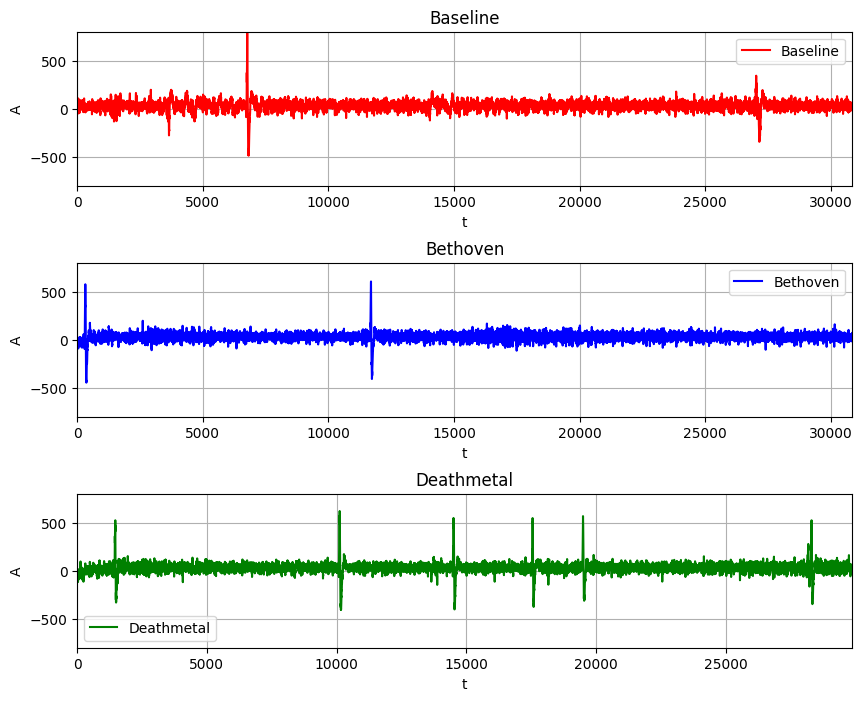

In [3]:
# Create the grid of figures (3 rows, 1 column)
fig, axes = plt.subplots(3, 1, figsize=(10, 8))  # Set desired figure size

# Function to format and plot each subplot
def format_and_plot(data,color, label, ax, limits,xlabel):
    ax.plot(data,color, label=label)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('A')
    ax.set_title(f'{label}')  # Include subplot number in title
    ax.set_ylim([-limits, limits])
    ax.set_xlim([0, len(data)])
    ax.grid()
    ax.legend()

# Plot each subplot using the function
format_and_plot(eeg_baseline,'r', 'Baseline', axes[0],800,'t')
format_and_plot(eeg_beth,'b', 'Bethoven', axes[1],800,'t')
format_and_plot(eeg_death,'g', 'Deathmetal', axes[2],800,'t')

# Adjust layout to prevent overlapping titles
plt.subplots_adjust(hspace=0.5)
plt.show()

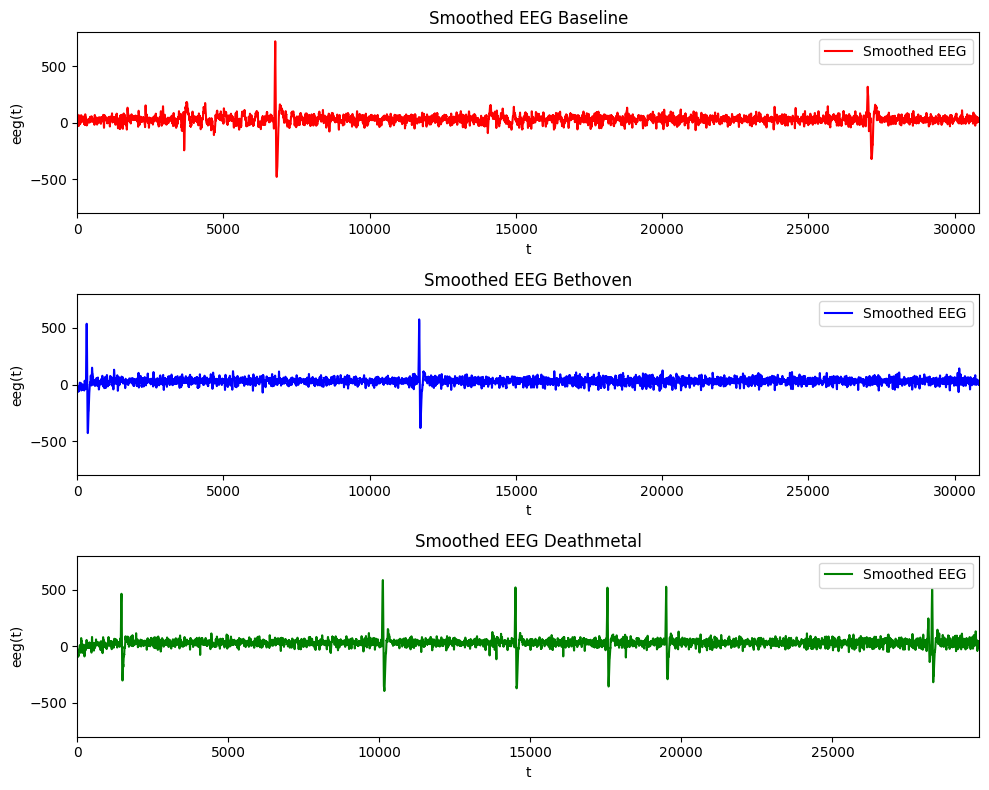

In [4]:
# La operación de convolución permite implementar el suavizado del Moving Average
windowlength = 10
avgeeg_beth = np.convolve(eeg_beth, np.ones((windowlength,))/windowlength, mode='same')
avgeeg_death = np.convolve(eeg_death, np.ones((windowlength,))/windowlength, mode='same')
avgeeg_baseline = np.convolve(eeg_baseline, np.ones((windowlength,))/windowlength, mode='same')

# Crear la grilla de gráficos (3 filas, 1 columna)
fig, axes = plt.subplots(3, 1, figsize=(10, 8))

# Primer gráfico: Señal EEG original
axes[0].plot(avgeeg_baseline, 'r', label='Smoothed EEG')
axes[0].set_xlabel('t')
axes[0].set_ylabel('eeg(t)')
axes[0].set_title(r'Smoothed EEG Baseline')
axes[0].set_ylim([-800, 800])
axes[0].set_xlim([0, len(avgeeg_baseline)])
axes[0].legend()

# Segundo gráfico: Señal suavizada bethoven
axes[1].plot(avgeeg_beth, 'b', label='Smoothed EEG')
axes[1].set_xlabel('t')
axes[1].set_ylabel('eeg(t)')
axes[1].set_title(r'Smoothed EEG Bethoven')
axes[1].set_ylim([-800, 800])
axes[1].set_xlim([0, len(avgeeg_beth)])
axes[1].legend()

# Tercer gráfico: Señal suavizada deathmetal
axes[2].plot(avgeeg_death, 'g', label='Smoothed EEG')
axes[2].set_xlabel('t')
axes[2].set_ylabel('eeg(t)')
axes[2].set_title(r'Smoothed EEG Deathmetal')
axes[2].set_ylim([-800, 800])
axes[2].set_xlim([0, len(avgeeg_death)])
axes[2].legend()

# Ajustar los espacios entre gráficos
plt.tight_layout()
plt.show()

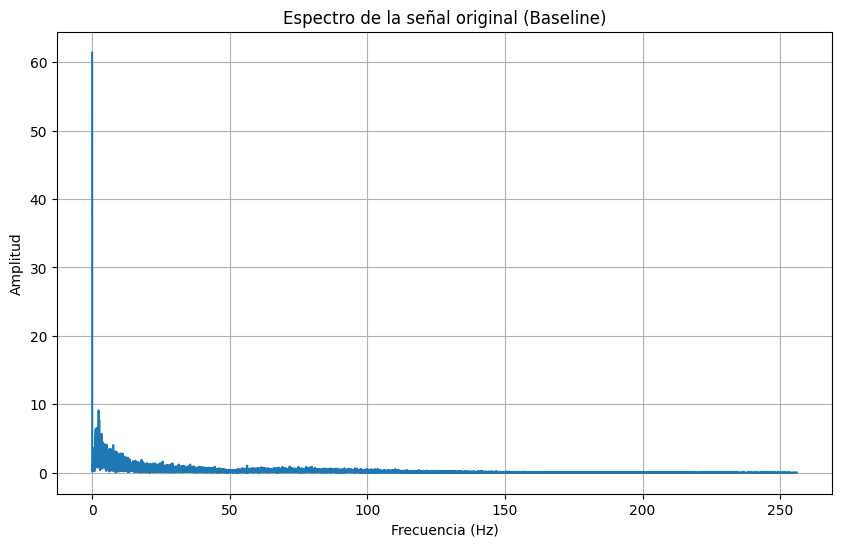

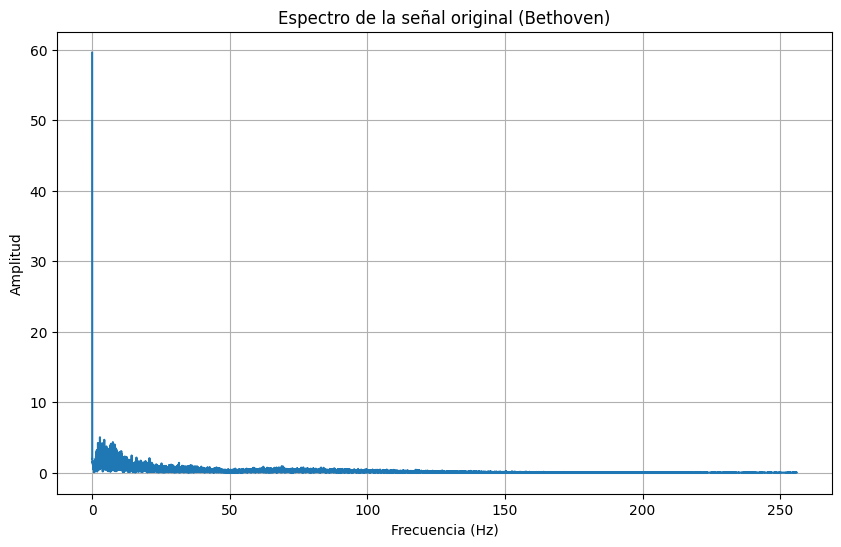

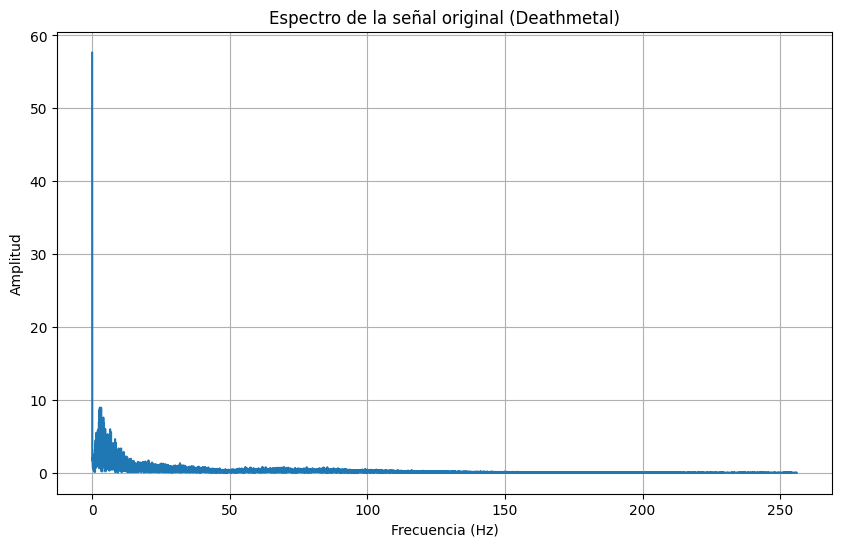

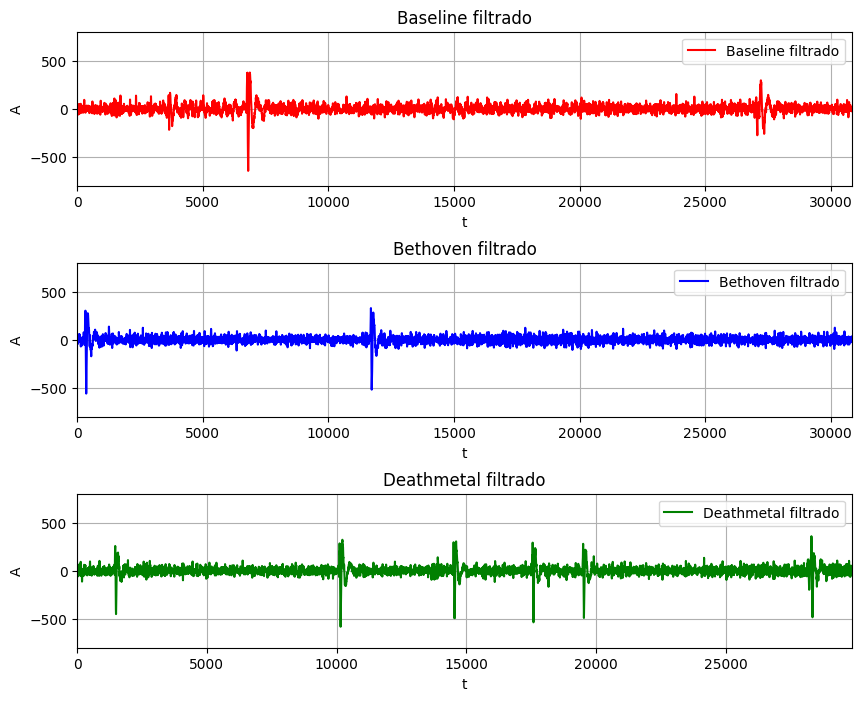

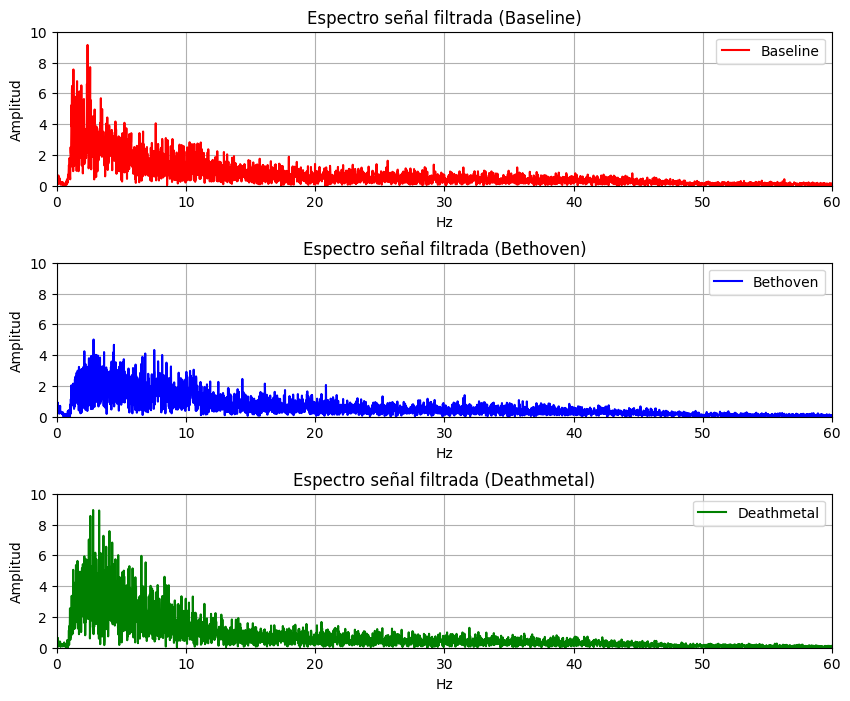

In [5]:
#-----FILTRO ESPECTRAL-----

# Filtro pasa-banda
def butter_bandpass(lowcut, highcut, fs, order=6):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="band")
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=6):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

Fs = 512  # Frecuencia de muestreo
N = len(eeg_baseline)  # Número de muestras en la señal
T = 1.0 / Fs  # Intervalo de tiempo entre muestras

#Baseline

# FFT de la señal original
yf = fft(eeg_baseline)
xf = np.linspace(0.0, Fs / 2, N // 2)  # Frecuencias positivas

plt.figure(figsize=(10, 6))
plt.plot(xf, 2.0 / N * np.abs(yf[:N // 2]))
plt.title("Espectro de la señal original (Baseline)")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Amplitud")
plt.grid()
plt.show()

# Aplicar filtro a la señal
lowcut = 1.0  # Frecuencia de corte baja (Hz)
highcut = 50.0  # Frecuencia de corte alta (Hz)

filtered_signal = butter_bandpass_filter(eeg_baseline, lowcut, highcut, Fs, order=6)

# FFT de la señal filtrada
yf_filtered = fft(filtered_signal)

#Bethoven

# FFT de la señal original
yf1 = fft(eeg_beth)
xf = np.linspace(0.0, Fs / 2, N // 2)  # Frecuencias positivas

plt.figure(figsize=(10, 6))
plt.plot(xf, 2.0 / N * np.abs(yf1[:N // 2]))
plt.title("Espectro de la señal original (Bethoven)")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Amplitud")
plt.grid()
plt.show()

# Aplicar filtro a la señal
lowcut = 1.0  # Frecuencia de corte baja (Hz)
highcut = 50.0  # Frecuencia de corte alta (Hz)

filtered_signal1 = butter_bandpass_filter(eeg_beth, lowcut, highcut, Fs, order=6)

# FFT de la señal filtrada
yf_filtered1 = fft(filtered_signal1)

#Deathmetal

# FFT de la señal original
yf2 = fft(eeg_death)
xf = np.linspace(0.0, Fs / 2, N // 2)  # Frecuencias positivas

plt.figure(figsize=(10, 6))
plt.plot(xf, 2.0 / N * np.abs(yf2[:N // 2]))
plt.title("Espectro de la señal original (Deathmetal)")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Amplitud")
plt.grid()
plt.show()


# Aplicar filtro a la señal
lowcut = 1.0  # Frecuencia de corte baja (Hz)
highcut = 50.0  # Frecuencia de corte alta (Hz)

filtered_signal2 = butter_bandpass_filter(eeg_death, lowcut, highcut, Fs, order=6)

# FFT de la señal filtrada
yf_filtered2 = fft(filtered_signal2)

# Crear la grilla de gráficos (3 filas, 1 columna)
fig, axes = plt.subplots(3, 1, figsize=(10, 8))

# Plot each subplot using the function
format_and_plot(filtered_signal,'r', 'Baseline filtrado', axes[0],800,'t')
format_and_plot(filtered_signal1,'b', 'Bethoven filtrado', axes[1],800,'t')
format_and_plot(filtered_signal2,'g', 'Deathmetal filtrado', axes[2],800,'t')

# Adjust layout to prevent overlapping titles
plt.subplots_adjust(hspace=0.5)
plt.show()


# Crear la grilla de gráficos (3 filas, 1 columna)
fig, axes = plt.subplots(3, 1, figsize=(10, 8))

# Primer gráfico: Espectro de la señal filtrada (Baseline)
axes[0].plot(xf, 2.0 / N * np.abs(yf_filtered[:N // 2]), 'r', label='Baseline')
axes[0].set_xlabel('Hz')
axes[0].set_ylabel('Amplitud')
axes[0].set_ylim([0, 10])
axes[0].set_xlim([0, 60])
axes[0].set_title('Espectro señal filtrada (Baseline)')
axes[0].grid()
axes[0].legend()

# Segundo gráfico: Espectro de la señal filtrada (Bethoven)
axes[1].plot(xf, 2.0 / N * np.abs(yf_filtered1[:N // 2]), 'b', label='Bethoven')
axes[1].set_xlabel('Hz')
axes[1].set_ylabel('Amplitud')
axes[1].set_ylim([0, 10])
axes[1].set_xlim([0, 60])
axes[1].set_title('Espectro señal filtrada (Bethoven)')
axes[1].grid()
axes[1].legend()

# Tercer gráfico: Espectro de la señal filtrada (Deathmetal)
axes[2].plot(xf, 2.0 / N * np.abs(yf_filtered2[:N // 2]), 'g', label='Deathmetal')
axes[2].set_xlabel('Hz')
axes[2].set_ylabel('Amplitud')
axes[2].set_ylim([0, 10])
axes[2].set_xlim([0, 60])
axes[2].set_title('Espectro señal filtrada (Deathmetal)')
axes[2].grid()
axes[2].legend()

# Ajustar el espacio entre gráficos
plt.subplots_adjust(hspace=0.5)
plt.show()

In [6]:
# Feature extraction

def rolling_statistics(data, window_size, label):
    data_series = pd.Series(data)
    rolling_stats = data_series.rolling(window=window_size)

    stats = pd.DataFrame({
        "media": rolling_stats.mean(),
        "desviacion_estandar": rolling_stats.std(),
        "maximo": rolling_stats.max(),
        "minimo": rolling_stats.min(),
        "RMS": rolling_stats.apply(lambda x: np.sqrt(np.mean(x**2)), raw=False),
        "señal": label
    })

    return stats

features_bethoven = rolling_statistics(filtered_signal1,256,0)
features_bethoven.dropna(inplace=True)

features_deathmetal = rolling_statistics(filtered_signal2,256,1)
features_deathmetal.dropna(inplace=True)

dataset = pd.concat([features_bethoven,features_deathmetal],axis=0)
dataset

,media,desviacion_estandar,maximo,minimo,RMS,señal
255,-2.557449,26.036749,58.067675,-70.369396,26.111391,0
256,-2.442857,26.112482,58.067675,-70.369396,26.175671,0
257,-2.289694,26.241384,58.067675,-70.369396,26.289980,0
258,-2.095830,26.439998,58.067675,-70.369396,26.471404,0
259,-1.861590,26.719307,59.573933,-70.369396,26.731968,0
...,...,...,...,...,...,...
29864,4.484123,37.694881,102.633233,-63.491881,37.887478,1
29865,4.402412,37.748721,102.633233,-63.491881,37.931265,1
29866,4.379101,37.763475,102.633233,-63.491881,37.943194,1
29867,4.409877,37.745997,102.633233,-63.491881,37.929433,1


In [7]:
# Armado del clasificador

# Paso 1: Preparar los datos
X = dataset.drop(columns=['señal'])  # Variables independientes (todas menos 'señal')
y = dataset['señal']  # Variable dependiente (columna 'señal')

# Paso 2: Dividir en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Paso 3: Entrenar el modelo SVM
model = SVC(kernel='rbf')  # Puedes probar otros kernels como 'rbf' o 'poly'
model.fit(X_train, y_train)


SVC()

In [ ]:
# Paso 4: Predecir en el conjunto de prueba
y_pred = model.predict(X_test)

In [10]:
# Paso 5: Evaluar el modelo

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:")
print(cm)

Matriz de Confusión:
[[5802  293]
 [4902 1045]]


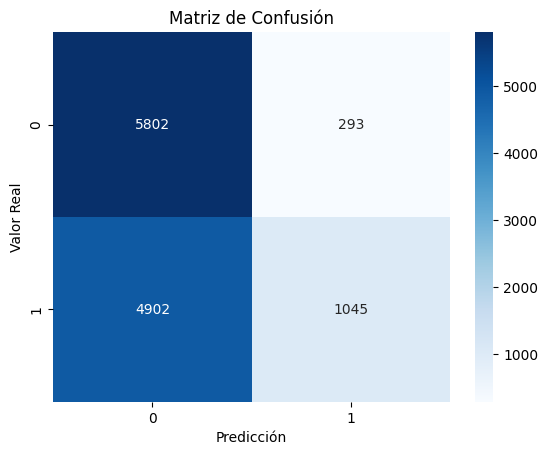

In [11]:
# Mostrar la matriz de confusión con un mapa de calor
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()


In [12]:

# Calcular el accuracy (exactitud)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Reporte con la sensibilidad, especificidad, y otros parámetros
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Extra: Sensibilidad y Especificidad
# Sensibilidad (recall): tp / (tp + fn)
# Especificidad: tn / (tn + fp)
tn, fp, fn, tp = cm.ravel()
sensibilidad = tp / (tp + fn)
especificidad = tn / (tn + fp)

print(f"Sensibilidad: {sensibilidad:.4f}")
print(f"Especificidad: {especificidad:.4f}")

Accuracy: 0.5686
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.54      0.95      0.69      6095
           1       0.78      0.18      0.29      5947

    accuracy                           0.57     12042
   macro avg       0.66      0.56      0.49     12042
weighted avg       0.66      0.57      0.49     12042

Sensibilidad: 0.1757
Especificidad: 0.9519
